In [1]:
!pip install torchdiffeq

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
import argparse
import logging
import time
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

parser = argparse.ArgumentParser()
parser.add_argument('--network', type=str, choices=['resnet', 'odenet'], default='odenet')
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=False, choices=[True, False])
parser.add_argument('--downsampling-method', type=str, default='conv', choices=['conv', 'res'])
parser.add_argument('--nepochs', type=int, default=160)
parser.add_argument('--data_aug', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--test_batch_size', type=int, default=1000)

parser.add_argument('--save', type=str, default='./experiment1')
parser.add_argument('--debug', action='store_true')
parser.add_argument('--gpu', type=int, default=0)
args, unknown = parser.parse_known_args()

# Set nepochs
args.nepochs = 11

# Set adjoint = True
args.adjoint = True

result = dict()
result["epoch"] = []
result["train_acc"] = []
result["test_acc"] = []
result["wall_clock_avg_batch"] = []
result["wall_clock_epoch"] = []


if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class ResBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.norm1 = norm(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.norm2 = norm(planes)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        shortcut = x

        out = self.relu(self.norm1(x))

        if self.downsample is not None:
            shortcut = self.downsample(out)

        out = self.conv1(out)
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(out)

        return out + shortcut


class ConcatConv2d(nn.Module):

    def __init__(self, dim_in, dim_out, ksize=3, stride=1, padding=0, dilation=1, groups=1, bias=True, transpose=False):
        super(ConcatConv2d, self).__init__()
        module = nn.ConvTranspose2d if transpose else nn.Conv2d
        self._layer = module(
            dim_in + 1, dim_out, kernel_size=ksize, stride=stride, padding=padding, dilation=dilation, groups=groups,
            bias=bias
        )

    def forward(self, t, x):
        tt = torch.ones_like(x[:, :1, :, :]) * t
        ttx = torch.cat([tt, x], 1)
        return self._layer(ttx)


class ODEfunc(nn.Module):

    def __init__(self, dim):
        super(ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = ConcatConv2d(dim, dim, 3, 1, 1)
        # self.bn1 = nn.BatchNorm2d(dim)
        self.norm2 = norm(dim)
        self.conv2 = ConcatConv2d(dim, dim, 3, 1, 1)
        # self.bn2 = nn.BatchNorm2d(dim)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.norm1(x)
        out = self.relu(out)
        out = self.conv1(t, out)
        # out = self.bn1(out) # Add BatchNorm
        out = self.norm2(out)
        out = self.relu(out)
        out = self.conv2(t, out)
        # out = self.bn2(out) # Add BatchNorm
        out = self.norm3(out)
        return out


class ODEBlock(nn.Module):

    def __init__(self, odefunc):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()

    def forward(self, x):
        self.integration_time = self.integration_time.type_as(x)
        # out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol, method='euler')
        # out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol, method='rk4')
        out = odeint(self.odefunc, x, self.integration_time, rtol=args.tol, atol=args.tol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value


class Flatten(nn.Module):

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()
        self.reset_sum()

    def reset(self):
        self.val = None
        self.avg = 0

    def reset_sum(self):
        self.time_sum = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.time_sum += val


def get_mnist_loaders(data_aug=False, batch_size=128, test_batch_size=1000, perc=1.0):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(28, padding=4),
            transforms.ToTensor(),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
    ])

    train_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_train), batch_size=batch_size,
        shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.MNIST(root='.data/mnist', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


def get_svhn_loaders(data_aug=False, batch_size=128, test_batch_size=1000):
    if data_aug:
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    train_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True
    )

    train_eval_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test),
        batch_size=test_batch_size, shuffle=False, num_workers=2, drop_last=True
    )

    return train_loader, test_loader, train_eval_loader


train_loader, test_loader, train_eval_loader = get_svhn_loaders(
    args.data_aug, args.batch_size, args.test_batch_size
)


def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


def learning_rate_with_decay(batch_size, batch_denom, batches_per_epoch, boundary_epochs, decay_rates):
    initial_learning_rate = args.lr * batch_size / batch_denom

    boundaries = [int(batches_per_epoch * epoch) for epoch in boundary_epochs]
    vals = [initial_learning_rate * decay for decay in decay_rates]

    def learning_rate_fn(itr):
        lt = [itr < b for b in boundaries] + [True]
        i = np.argmax(lt)
        return vals[i]

    return learning_rate_fn


def one_hot(x, K):
    return np.array(x[:, None] == np.arange(K)[None, :], dtype=int)


def accuracy(model, dataset_loader):
    total_correct = 0
    for x, y in dataset_loader:
        x = x.to(device)
        y = one_hot(np.array(y.numpy()), 10)

        target_class = np.argmax(y, axis=1)
        predicted_class = np.argmax(model(x).cpu().detach().numpy(), axis=1)
        total_correct += np.sum(predicted_class == target_class)
    return total_correct / len(dataset_loader.dataset)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def get_logger(logpath, filepath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)
    logger.info(filepath)
    with open(filepath, "r") as f:
        logger.info(f.read())

    for f in package_files:
        logger.info(f)
        with open(f, "r") as package_f:
            logger.info(package_f.read())

    return logger


if __name__ == '__main__':

    makedirs(args.save)
    logger = get_logger(logpath=os.path.join(args.save, 'logs'), filepath=os.path.abspath('/content/drive/MyDrive/Colab Notebooks/cs376.ipynb'))
    logger.info(args)

    device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

    is_odenet = args.network == 'odenet'

    if args.downsampling_method == 'conv':
        downsampling_layers = [
            nn.Conv2d(3, 64, 3, 1, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        ]

        # downsampling_layers = [
        #     nn.Conv2d(1, 64, 3, 1),
        #     norm(64),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(64, 64, 4, 2, 1),
        #     norm(64),
        #     nn.ReLU(inplace=True),
        #     nn.Conv2d(64, 64, 4, 2, 1),
        # ]
    elif args.downsampling_method == 'res':
        downsampling_layers = [
            nn.Conv2d(1, 64, 3, 1),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
            ResBlock(64, 64, stride=2, downsample=conv1x1(64, 64, 2)),
        ]

    feature_layers = [ODEBlock(ODEfunc(64))] if is_odenet else [ResBlock(64, 64) for _ in range(6)]
    fc_layers = [norm(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Dropout(p=0.5), nn.Linear(64, 10)] # Add dropout
    # fc_layers = [norm(64),nn.BatchNorm2d(64), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)] # Add BatchNorm2d
    # fc_layers = [norm(64),nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d((1, 1)), Flatten(), nn.Linear(64, 10)]

    model = nn.Sequential(*downsampling_layers, *feature_layers, *fc_layers).to(device)

    logger.info(model)
    logger.info('Number of parameters: {}'.format(count_parameters(model)))

    criterion = nn.CrossEntropyLoss().to(device)

    train_loader, test_loader, train_eval_loader = get_svhn_loaders(
    args.data_aug, args.batch_size, args.test_batch_size
    )

    # train_loader, test_loader, train_eval_loader = get_mnist_loaders(
    #     args.data_aug, args.batch_size, args.test_batch_size
    # )



    data_gen = inf_generator(train_loader)
    batches_per_epoch = len(train_loader)

    lr_fn = learning_rate_with_decay(
        args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[60, 100, 140],
        # args.batch_size, batch_denom=128, batches_per_epoch=batches_per_epoch, boundary_epochs=[1, 4, 7],
        decay_rates=[1, 0.1, 0.01, 0.001]
        # decay_rates=[1, 0.05, 0.01, 0.005]
    )

    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=0.9)

    # optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    best_acc = 0
    batch_time_meter = RunningAverageMeter()
    f_nfe_meter = RunningAverageMeter()
    b_nfe_meter = RunningAverageMeter()
    end = time.time()

    for itr in range(args.nepochs * batches_per_epoch):

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr_fn(itr)

        optimizer.zero_grad()
        x, y = data_gen.__next__()
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        if is_odenet:
            nfe_forward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        loss.backward()
        optimizer.step()

        if is_odenet:
            nfe_backward = feature_layers[0].nfe
            feature_layers[0].nfe = 0

        batch_time_meter.update(time.time() - end)
        if is_odenet:
            f_nfe_meter.update(nfe_forward)
            b_nfe_meter.update(nfe_backward)
        end = time.time()

        if itr % batches_per_epoch == 0:
            with torch.no_grad():
                train_acc = accuracy(model, train_eval_loader)
                val_acc = accuracy(model, test_loader)
                if val_acc > best_acc:
                    torch.save({'state_dict': model.state_dict(), 'args': args}, os.path.join(args.save, 'model.pth'))
                    best_acc = val_acc
                logger.info(
                    "Epoch {:04d} | Time {:.3f} ({:.3f}) | NFE-F {:.1f} | NFE-B {:.1f} | "
                    "Train Acc {:.4f} | Test Acc {:.4f} | Wall-clock time Avg (batch) {:.3f} | Wall-clock time (epoch) {:.3f}".format(
                        itr // batches_per_epoch, batch_time_meter.val, batch_time_meter.avg, f_nfe_meter.avg,
                        b_nfe_meter.avg, train_acc, val_acc, batch_time_meter.time_sum / batches_per_epoch, batch_time_meter.time_sum
                    )
                )
                result["epoch"].append(itr // batches_per_epoch)
                result["train_acc"].append(train_acc)
                result["test_acc"].append(val_acc)
                result["wall_clock_avg_batch"].append(batch_time_meter.time_sum / batches_per_epoch)
                result["wall_clock_epoch"].append(batch_time_meter.time_sum)
                batch_time_meter.reset_sum()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:root:/content/drive/MyDrive/Colab Notebooks/cs376.ipynb
/content/drive/MyDrive/Colab Notebooks/cs376.ipynb
INFO:root:{"nbformat":4,"nbformat_minor":0,"metadata":{"colab":{"provenance":[],"gpuType":"T4","authorship_tag":"ABX9TyM78APPB89veb13awdIaFRK"},"kernelspec":{"name":"python3","display_name":"Python 3"},"language_info":{"name":"python"},"accelerator":"GPU"},"cells":[{"cell_type":"code","execution_count":null,"metadata":{"id":"jyTydfxS5UN8"},"outputs":[],"source":["!pip install torchdiffeq"]},{"cell_type":"code","source":["from google.colab import drive\n","drive.mount('/content/drive/')"],"metadata":{"id":"nXeYcJ4Y5b_f"},"execution_count":null,"outputs":[]},{"cell_type":"code","source":["import os\n","import argparse\n","import logging\n","import time\n","import numpy as np\n","import torch\n","import torch.nn as nn\n","from torch.utils.data import DataLoader\n","import torchvision.datasets as datasets\n","import torchvision.transforms as transforms\n","\n","parser = argparse.

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:root:Epoch 0000 | Time 2.369 (2.369) | NFE-F 32.0 | NFE-B 38.0 | Train Acc 0.1009 | Test Acc 0.0996 | Wall-clock time Avg (batch) 0.006 | Wall-clock time (epoch) 2.369
Epoch 0000 | Time 2.369 (2.369) | NFE-F 32.0 | NFE-B 38.0 | Train Acc 0.1009 | Test Acc 0.0996 | Wall-clock time Avg (batch) 0.006 | Wall-clock time (epoch) 2.369
INFO:root:Epoch 0001 | Time 0.463 (0.208) | NFE-F 20.6 | NFE-B 20.4 | Train Acc 0.3432 | Test Acc 0.3422 | Wall-clock time Avg (batch) 0.242 | Wall-clock time (epoch) 94.324
Epoch 0001 | Time 0.463 (0.208) | NFE-F 20.6 | NFE-B 20.4 | Train Acc 0.3432 | Test Acc 0.3422 | Wall-clock time Avg (batch) 0.242 | Wall-clock time (epoch) 94.324
INFO:root:Epoch 0002 | Time 0.410 (0.174) | NFE-F 20.3 | NFE-B 20.2 | Train Acc 0.4150 | Test Acc 0.4127 | Wall-clock time Avg (batch) 0.219 | Wall-clock time (epoch) 85.473
Epoch 0002 | Time 0.410 (0.174) | NFE-F 20.3 | NFE-B 20.2 | Train Acc 0.4150 | Test Acc 0.4127 | Wall-clock time Avg (batch) 0.219 | Wall-clock time (ep

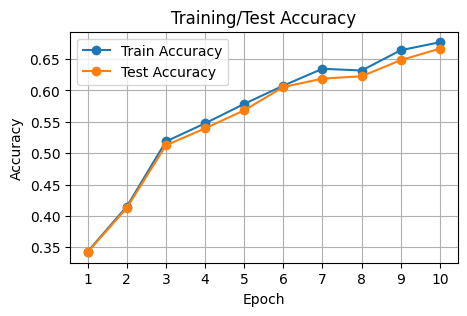

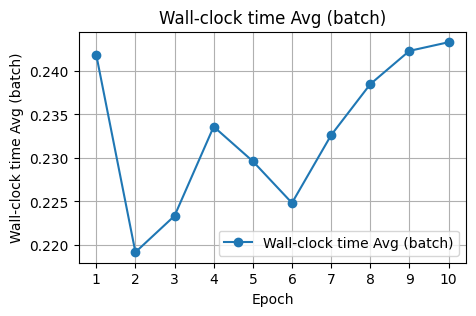

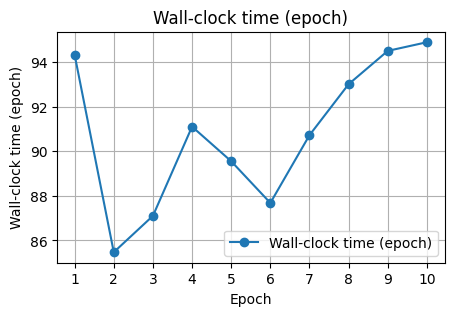

Wall-clock average time for epoch :  90.83630135059357


In [4]:
import matplotlib.pyplot as plt

epochs = result['epoch'][1:]
train_acc = result['train_acc'][1:]
test_acc = result['test_acc'][1:]
wall_clock_avg_batch = result['wall_clock_avg_batch'][1:]
wall_clock_epoch = result['wall_clock_epoch'][1:]

# Training/testing accuracy
plt.figure(figsize=(5, 3))
plt.plot(epochs, train_acc, marker='o', label='Train Accuracy')
plt.plot(epochs, test_acc, marker='o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training/Test Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

# Wall-clock average time per batch
plt.figure(figsize=(5, 3))
plt.plot(epochs, wall_clock_avg_batch, marker='o', label='Wall-clock time Avg (batch)')
plt.xlabel('Epoch')
plt.ylabel('Wall-clock time Avg (batch)')
plt.title('Wall-clock time Avg (batch)')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

# Wall-clock time per epoch
plt.figure(figsize=(5, 3))
plt.plot(epochs, wall_clock_epoch, marker='o', label='Wall-clock time (epoch)')
plt.xlabel('Epoch')
plt.ylabel('Wall-clock time (epoch)')
plt.title('Wall-clock time (epoch)')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()

print("Wall-clock average time for epoch : ", sum(wall_clock_epoch) / len(wall_clock_epoch))
